# Imports

In [1]:
import time
import os,pickle
import numpy as np
from common import misc
from matplotlib import pyplot as plt
from scipy.special import ellipk,ellipe,j0
from scipy.integrate import quad,dblquad
from numba import njit
from common import numerical_recipes as numrec
from common.baseclasses import AWA
from common import plotting
from importlib import reload
from scipy.linalg import eig,eigh,svd

import ProbeCavityEigenfields as PCE
from ProbeCavityEigenfields import RotationalMoM as RotMOM

<plotting>:
	Registered colormaps "Warm" and "Warm_r"...
<plotting>:
	Registered colormaps "vanheum" and "vanheum_r"...
<plotting>:
	Registered colormaps "NT-MDT" and "NT-MDT_r"...
<plotting>:
	Registered colormaps "rainbow" and "rainbow_r"...
<plotting>:
	Registered colormaps "jingdi" and "jingdi_r"...
<plotting>:
	Registered colormaps "Halcyon" and "Halcyon_r"...
<plotting>:
	Registered colormaps "Cold" and "Cold_r"...
<plotting>:
	Registered colormaps "Sky" and "Sky_r"...
<plotting>:
	Registered colormaps "Gwyddion.net" and "Gwyddion.net_r"...
<plotting>:
	Registered colormaps "BlueRed" and "BlueRed_r"...
<plotting>:
	Registered colormaps "vanheum3" and "vanheum3_r"...
<plotting>:
	Registered colormaps "vanheum2" and "vanheum2_r"...


/Users/alexandersmcleod/tools/python/common/plotting.py:56: MatplotlibDeprecationWarning: Passing raw data via parameters data and lut to register_cmap() is deprecated since 3.3 and will become an error two minor releases later. Instead use: register_cmap(cmap=LinearSegmentedColormap(name, data, lut))
  pyplot.register_cmap(name='BWR', data=cdict)
/Users/alexandersmcleod/tools/python/common/plotting.py:78: MatplotlibDeprecationWarning: Passing raw data via parameters data and lut to register_cmap() is deprecated since 3.3 and will become an error two minor releases later. Instead use: register_cmap(cmap=LinearSegmentedColormap(name, data, lut))
  pyplot.register_cmap(name='BWR2', data=cdict)
/Users/alexandersmcleod/tools/python/common/plotting.py:100: MatplotlibDeprecationWarning: Passing raw data via parameters data and lut to register_cmap() is deprecated since 3.3 and will become an error two minor releases later. Instead use: register_cmap(cmap=LinearSegmentedColormap(name, data, l

# Build a Probe

In [2]:
#-- Geometric definitions - explicit lengths in nanometers

a_nm=20
taper_angle=35
Rtop=0
WL_THz_nm=300e3 #300 microns = 1 THz

#-- Geometric definitions - relative to probe radius

L=19e3/a_nm
freq_THz=a_nm/WL_THz_nm
freq0=30*freq_THz
gap0=1

#-- Build probe

Nsubnodes=2
P=PCE.Probe(Nnodes=244,Nsubnodes=Nsubnodes,L=L,quadrature=numrec.TS,\
                 a=1,taper_angle=taper_angle,geometry='hyperboloid',Rtop=Rtop,
            freq=freq0,gap=gap0)

#-- probe attributes

zsprobe=P.get_zs()
rsprobe=P.get_radii()
k=P.get_k()

<__init__.get_probe_radii>:
	Getting geometry for selection "hyperboloid"...
<RotationalMoM.Discretization.__init__>:
	Discretizing body of revolution over 244 annular nodes and 2 subnodes...


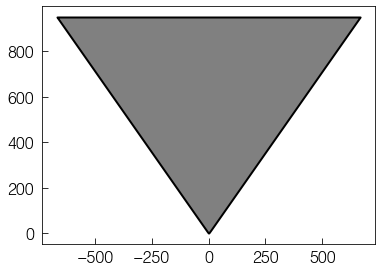

In [3]:
#-- Plot probe shape

plt.figure()
#plt.plot(-radii,zs,radii,zs,color='b')
xsprobe=np.append(-rsprobe[::-1],rsprobe)
ysprobe=np.append(zsprobe[::-1],zsprobe)
plt.fill_between(x=xsprobe,
                 y1=ysprobe,y2=L,
                 color='gray',edgecolor='k',lw=2)
plt.gca().set_aspect('equal')

(-1.0, 5.0)

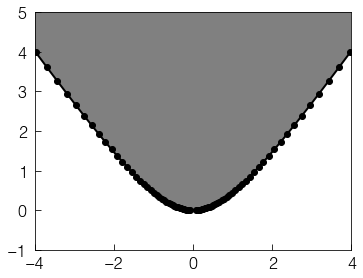

In [4]:
#-- Plot probe shape - zoom

plt.figure()
#plt.plot(-radii,zs,radii,zs,color='b')
plt.fill_between(x=xsprobe,
                 y1=ysprobe,y2=L,
                 color='gray',edgecolor='k',lw=2)
plt.plot(xsprobe,ysprobe,marker='o',ls='',color='k')
plt.gca().set_aspect('equal')
plt.xlim(-4,4)
plt.ylim(-1,5)

## Solve eigenoscillations

<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
<RotationalMoM.ImpedanceMatrix>:
	Preparing dynamic self impedance matrix...
	Progress: 99.59%	Total quadrature time: 7.76s, time per quadrature evaluation: 1.30E-04s


"\nr0=P.get_eigenrhos()[:10]\nr=GapSpectroscopy.get_eigenrhos_AWA().cslice[:10,gap]\nr=AWA(sorted(r,key=lambda r: np.abs(r)))\ndr=(r-r0)\ndr.real.plot(alpha=.3,color='r',lw=10)\ndr.imag.plot(alpha=.3,color='b',lw=10)\nprint(np.abs(dr).max())"

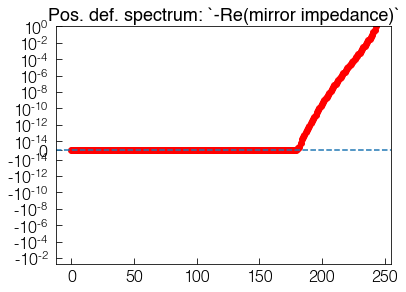

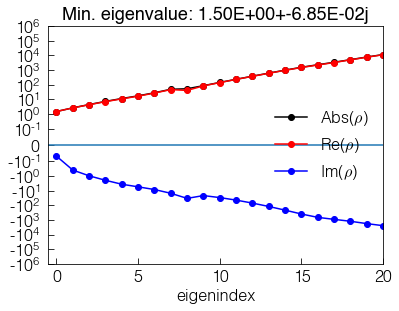

In [5]:
gap=1
P.set_gap(gap)
P.get_mirror_impedance(sommerfeld=True,k=0,recompute=True,
                       Nkappas=244*4,kappa_max=10/gap,kappa_min=None,qquadrature=numrec.GL)
P.solve_eigenmodes(plot=True,condition_ZS=False)
P.plot_eigenrhos()

"""
r0=P.get_eigenrhos()[:10]
r=GapSpectroscopy.get_eigenrhos_AWA().cslice[:10,gap]
r=AWA(sorted(r,key=lambda r: np.abs(r)))
dr=(r-r0)
dr.real.plot(alpha=.3,color='r',lw=10)
dr.imag.plot(alpha=.3,color='b',lw=10)
print(np.abs(dr).max())"""

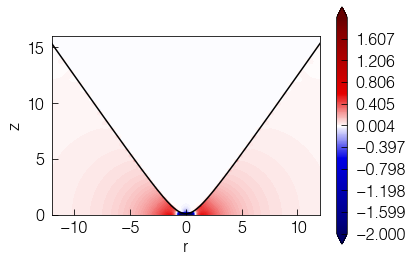

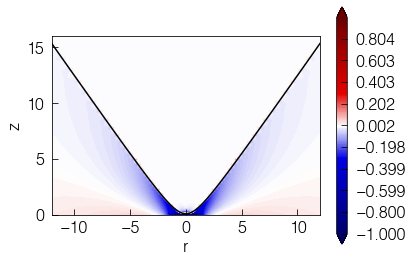

In [6]:
## --- Visualize the E-field from an eigenoscillation
#
# Computed in quasistatic approximation from exact electrodynamic charge solution
# Sums the probe field and the reflected eigenoscillation

n=1
Q=P.get_eigencharge(n)
eigenrho=P.get_eigenrho(n)
cl=2

at_rs=np.linspace(0,12,100)
at_zs=np.linspace(0,16,150)
Er,Ez=P.computeEfieldImages(Q, rho=eigenrho,
                            rs_out=at_rs, zs_out=at_zs,\
                            display=True,mirror_double_images=True)



plt.figure()
plt.plot(xsprobe,ysprobe+gap,color='k')
plt.gca().set_aspect('equal')
Ez.real.plot(plotter=plt.contourf,cmap='BWR',\
             levels=np.linspace(-cl,cl,500),extend='both')
plt.clim(-cl,cl)
plt.xlim(-at_rs.max(),at_rs.max())
plt.ylim(0,at_zs.max())
plt.gca().set_aspect('equal')

plt.figure()
plt.plot(xsprobe,ysprobe+gap,color='k')
plt.gca().set_aspect('equal')
Er.real.plot(plotter=plt.contourf,cmap='BWR',\
             levels=np.linspace(-cl/2,cl/2,500),extend='both')
plt.clim(-cl/2,cl/2)
plt.xlim(-at_rs.max(),at_rs.max())
plt.ylim(0,at_zs.max())
plt.gca().set_aspect('equal')

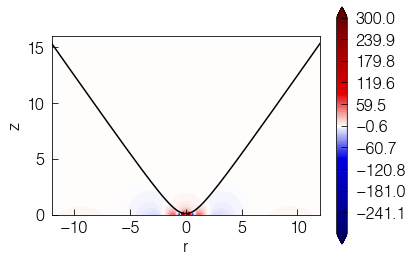

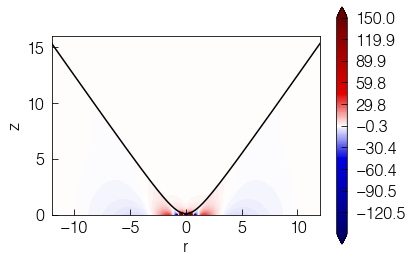

In [7]:
#--- Visualize the E-field from an eigenoscillation
#
# Computed in quasistatic approximation from exact electrodynamic charge solution
# Sums the probe field and the reflected eigenoscillation

n=7
Q=P.get_eigencharge(n)
eigenrho=P.get_eigenrho(n)
cl=300

at_rs=np.linspace(0,12,100)
at_zs=np.linspace(0,16,150)
Er,Ez=P.computeEfieldImages(Q, rho=eigenrho,
                            rs_out=at_rs, zs_out=at_zs,\
                            display=True,mirror_double_images=True)



plt.figure()
plt.plot(xsprobe,ysprobe+gap,color='k')
plt.gca().set_aspect('equal')
Ez.real.plot(plotter=plt.contourf,cmap='BWR',\
             levels=np.linspace(-cl,cl,500),extend='both')
plt.clim(-cl,cl)
plt.xlim(-at_rs.max(),at_rs.max())
plt.ylim(0,at_zs.max())
plt.gca().set_aspect('equal')

plt.figure()
plt.plot(xsprobe,ysprobe+gap,color='k')
plt.gca().set_aspect('equal')
Er.real.plot(plotter=plt.contourf,cmap='BWR',\
             levels=np.linspace(-cl/2,cl/2,500),extend='both')
plt.clim(-cl/2,cl/2)
plt.xlim(-at_rs.max(),at_rs.max())
plt.ylim(0,at_zs.max())
plt.gca().set_aspect('equal')

## Excite the probe, see induced charge and scattered field

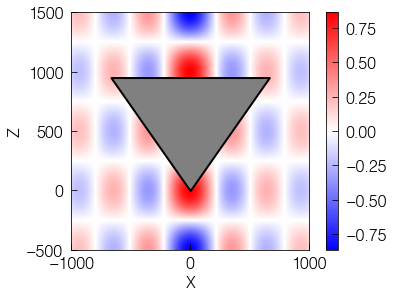

In [8]:
Er0,Ez0=PCE.EBesselBeamFF(angle=60, k = k)
#Zs,Xs=np.meshgrid(zs,xs)
Xs,Zs=np.ogrid[-1000:1000:1000j,
               -500:1500:1000j]; xs=Xs.squeeze(); zs=Zs.squeeze()
er0,ez0=Er0(Xs,Zs),Ez0(Xs,Zs)
ez0=AWA(ez0,axes=[xs,zs],axis_names=['X','Z'])
er0=AWA(er0,axes=[xs,zs],axis_names=['X','Z'])
ez0.real.plot(cmap='bwr')

plt.fill_between(x=xsprobe,
                 y1=np.append(zsprobe[::-1],zsprobe),y2=L,
                 color='gray',edgecolor='k',lw=2)
plt.gca().set_aspect('equal')

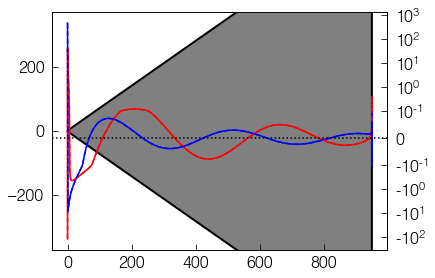

In [9]:
beta=2+1j; Nmodes=20

#-- Solve induced charge directly with boundary element method
Q1=P.solve_induced_charge_direct(Er=Er0,Ez=Ez0,rho=beta)
q1=P.get_charge_density(Q1)

#-- Solve induced charge with eigenoscillation expansion
Q2=P.solve_induced_charge_eigen(Er=Er0,Ez=Ez0,rho=beta, Veff=True, Nmodes=Nmodes)
q2=P.get_charge_density(Q2)


plt.fill_between(x=zsprobe,
                 y1=rsprobe,y2=-rsprobe,
                 color='gray',edgecolor='k',lw=2)
plt.gca().set_aspect('equal')

ax2=plt.twinx()
q1.real.plot(color='r')
q1.imag.plot(color='b')

q2.real.plot(color='r',ls='--')
q2.imag.plot(color='b',ls='--')

plt.gca().set_yscale('symlog',linthresh=.1)
plt.axhline(0,ls=':',color='k')

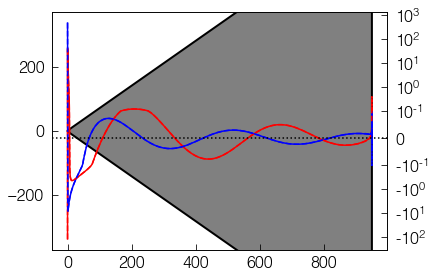

In [10]:
#-- Solve induced charge in a "scattered charge" formalism
Q0=P.solve_induced_charge_direct(Er=Er0,Ez=Ez0,rho=0)
q0=P.get_charge_density(Q0)

rhos=P.get_eigenrhos()
Qs=P.get_eigencharges()

excs=P.get_eigenexcitations(Er=Er0,Ez=Ez0,recompute=True)
dQs=[Q * beta/(rho*(rho-beta)) * exc for rho,exc,Q in zip(rhos,excs,Qs)]
dQ=np.sum(dQs[:Nmodes],axis=0)

Qtest=Q0-dQ
qtest =P.get_charge_density(Qtest)

#---
plt.fill_between(x=zsprobe,
                 y1=rsprobe,y2=-rsprobe,
                 color='gray',edgecolor='k',lw=2)
plt.gca().set_aspect('equal')
ax2.set_ylim(-1000,1000)

ax2=plt.twinx()
q1.real.plot(color='r')
q1.imag.plot(color='b')

qtest.real.plot(color='r',ls='--')
qtest.imag.plot(color='b',ls='--')
plt.gca().set_yscale('symlog',linthresh=.1)
plt.axhline(0,ls=':',color='k')

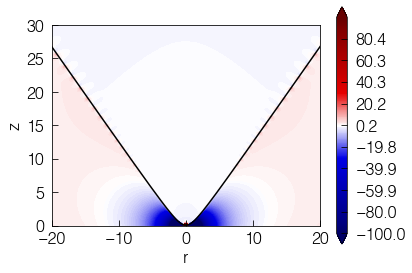

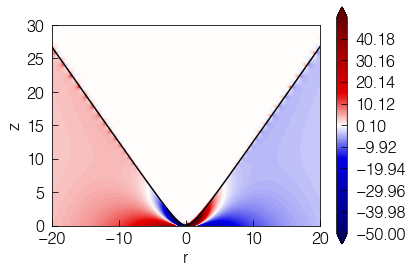

In [11]:
#--- Visualize the scattered E-field (and incident)
#
# Computed in quasistatic approximation from exact electrodynamic charge solution
# Sums incident field with that from the probe & sample (scattered field)

cl=100

at_rs=np.linspace(-20,20,200)
at_zs=np.linspace(0,30,150)
er0 = Er0(at_rs[:,np.newaxis],at_zs[np.newaxis,:])
ez0 = Ez0(at_rs[:,np.newaxis],at_zs[np.newaxis,:])

erScat,ezScat=P.computeEfieldImages(Q1, rho=beta,
                                    rs_out=at_rs, zs_out=at_zs,\
                                    display=True,mirror_double_images=False)

er = er0 + erScat
ez = ez0 + ezScat

plt.figure()
plt.plot(xsprobe,ysprobe+gap,color='k')
plt.gca().set_aspect('equal')
ez.real.plot(plotter=plt.contourf,cmap='BWR',\
             levels=np.linspace(-cl,cl,500),extend='both')
plt.clim(-cl,cl)
plt.xlim(-at_rs.max(),at_rs.max())
plt.ylim(0,at_zs.max())
plt.gca().set_aspect('equal')

plt.figure()
plt.plot(xsprobe,ysprobe+gap,color='k')
plt.gca().set_aspect('equal')
er.real.plot(plotter=plt.contourf,cmap='BWR',\
             levels=np.linspace(-cl/2,cl/2,500),extend='both')
plt.clim(-cl/2,cl/2)
plt.xlim(-at_rs.max(),at_rs.max())
plt.ylim(0,at_zs.max())
plt.gca().set_aspect('equal')

# Eigenoscillation spectroscopy

In [12]:
from ProbeCavityEigenfields import ProbeSpectroscopy as PS

## Probe-surface gap spectroscopy

In [13]:
#--- Define function that will run our spectroscopy
# Make it auto-pickling so that subsequent `get..` calls reload rather than recompute the result

gaps = np.logspace(-1,1,100)

@misc.autopickle('ProbeGapSpectroscopy_taper=%i.pickle'%taper_angle)
def getGapSpectroscopy(P, gaps=gaps):
    
    P.set_freq(freq0)
    #Don't supply explicit quadrature object, or it will have to be pickled for parallel dispatch
    GS = P.gapSpectroscopy(gaps,recompute=True,Nmodes=15,sommerfeld=True,\
                           Nkappas=244*4,qquadrature='GL')
    #GS = P.gapSpectroscopy(gaps,recompute=True,sommerfeld=False)
    #GS.classify_eigensets(reversed=True)
    
    return GS

<RotationalMoM.ImpedanceMatrix>:
	Preparing dynamic self impedance matrix...
	Progress: 99.59%	Total quadrature time: 7.22s, time per quadrature evaluation: 1.21E-04s
Starting gap=0.1
Starting gap=0.1
Starting gap=0.11
Starting gap=0.11
Starting gap=0.12
Starting gap=0.13
Starting gap=0.13
Starting gap=0.14
Finished gap=0.1, elapsed time: 0.9 s
Finished gap=0.1, elapsed time: 1 s
Finished gap=0.11, elapsed time: 1.1 s
Finished gap=0.12, elapsed time: 1.1 sFinished gap=0.11, elapsed time: 1.1 s

Finished gap=0.13, elapsed time: 1.1 s
Finished gap=0.13, elapsed time: 1.1 s
Finished gap=0.14, elapsed time: 1.1 s
Starting gap=0.15
Starting gap=0.15
Starting gap=0.16
Starting gap=0.17
got results!
Starting gap=0.17
Starting gap=0.18
Starting gap=0.19
Starting gap=0.2
Finished gap=0.15, elapsed time: 0.95 s
Finished gap=0.15, elapsed time: 0.95 s
Finished gap=0.17, elapsed time: 0.94 s
Finished gap=0.16, elapsed time: 1 s
Finished gap=0.17, elapsed time: 0.94 s
Finished gap=0.18, elapsed tim

Text(0.5, 0, 'Gap')

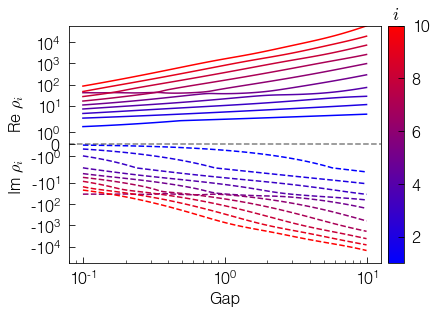

In [14]:
GapSpectroscopy = getGapSpectroscopy(P,recompute=False,overwrite=False)
GapSpectroscopy.plot_eigenrhos()
plt.gcf().axes[0].set_xlabel('Gap')

Text(0.5, 0, 'gap')

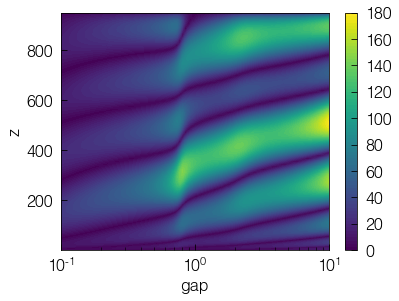

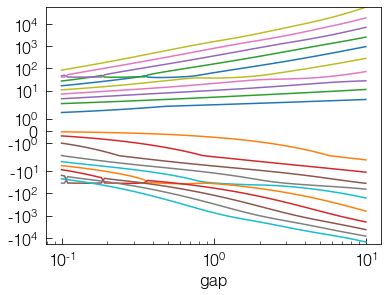

In [15]:
#--- Debugging
# Just looking to check the extraction of eigencharges and eigenvalues was a continuous one

coords=list(GapSpectroscopy._recorded_eigencharges.keys())

n=4
charges=[GapSpectroscopy._recorded_eigencharges[coord][n] \
         for coord in coords]
charges=AWA(charges,axes=[coords,charges[0].axes[0]],
            axis_names=['gap','z'])
np.abs(charges.real).plot(plotter=plt.contourf)
plt.gca().set_xscale('log')

plt.figure()
for n in range(10):
    rhos=[GapSpectroscopy._recorded_eigenrhos[coord][n] \
             for coord in coords]
    rhos=np.array(rhos)

    plt.plot(coords,rhos.real,coords,rhos.imag)
plt.gca().set_xscale('log')
plt.gca().set_yscale('symlog')
plt.xlabel('gap')



### Predict a nano-infrared spectroscopy experiment, using computed eigenoscillations

In [16]:
Encoding = PS.EncodedEigenfields(GapSpectroscopy,gap0=1,Nmodes=20,Nkappas=244*4,kappa_max=2*np.pi*10)

<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigencharges_AWA>:
	For Nmodes=20, there were 100 mutual spectroscopy coordinates.
	Aligning eigencharge signage...
<ProbeSpectroscopy.EncodedEigenfields.__init__>:
	Encoding eigenfields to gap=1 across 100 gap values from gap=0.1 to 10...
<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 9.77E-01...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_brightnesses_AWA>:
	Computing brightnesses across 100 spectroscopy coordinates...


In [17]:
from NearFieldOptics import Materials as M
rp = lambda freq,q: M.SiO2_300nm.reflection_p(freq/(a_nm*1e-7),\
                                              q/(a_nm*1e-7))

at_gaps = np.logspace(-1,.5,50)
freqs=np.linspace(15,50,200)*freq_THz

Erad = [Encoding.EradVsGap(at_gaps=at_gaps, freq=at_freq, rp=rp) for at_freq in freqs]
Erad=AWA(Erad,axes=[freqs/freq_THz,at_gaps],axis_names=['Frequency (THz)','Gap'])

<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Bi2Se3_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "PMMA_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "sio2_300nm_extracted_epsilon_cone_A=2a.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "TaS2_eps_230K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "TaS2_eps_30K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Erik_BSTS_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "VO2_295K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "VO2_360K.csv"...
<material_types.Ta

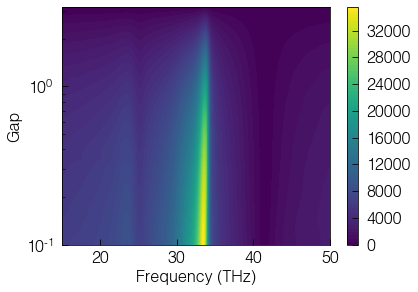

In [18]:
Erad_away = Erad[:,-1][:,np.newaxis]
np.abs(Erad-Erad_away).plot(plotter=plt.contourf)
plt.gca().set_yscale("log")

<>:8: DeprecationWarning: invalid escape sequence \m
<>:8: DeprecationWarning: invalid escape sequence \m
<>:8: DeprecationWarning: invalid escape sequence \m
/var/folders/67/32mwwcnj2pl1mtqhfc7mzlz80000gn/T/ipykernel_4528/3127234751.py:8: DeprecationWarning: invalid escape sequence \m
  plt.ylabel('$|E_\mathrm{scat}$|',fontsize=20)


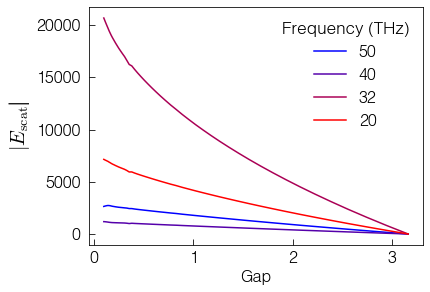

In [19]:
at_freqs = 20,32,40,50
cs=plotting.bluered_colors(len(at_freqs))

for at_freq in at_freqs[::-1]:
    Erad_at_freq=(Erad-Erad[:,-1][:,np.newaxis]).cslice[at_freq]
    np.abs(Erad_at_freq).plot(label=at_freq,color=next(cs))
                                                        
plt.ylabel('$|E_\mathrm{scat}$|',fontsize=20)
plt.legend(title='Frequency (THz)')

In [20]:
signals=Encoding.EradSpectrumDemodulated(freqs, rp=rp,
                                        gapmin=.1, amplitude=1.9,
                                        Ngaps=24*2, demod_order=5)
signals_ref=Encoding.EradSpectrumDemodulated(freqs=P.get_freq(),rp=1,
                                            gapmin=.1, amplitude=1.9,
                                            Ngaps=24*2, demod_order=5)

	Computing at freq=1.000E-03...
	Computing at freq=1.012E-03...
	Computing at freq=1.023E-03...
	Computing at freq=1.035E-03...
	Computing at freq=1.047E-03...
	Computing at freq=1.059E-03...
	Computing at freq=1.070E-03...
	Computing at freq=1.082E-03...
	Computing at freq=1.094E-03...
	Computing at freq=1.106E-03...
	Computing at freq=1.117E-03...
	Computing at freq=1.129E-03...
	Computing at freq=1.141E-03...
	Computing at freq=1.152E-03...
	Computing at freq=1.164E-03...
	Computing at freq=1.176E-03...
	Computing at freq=1.188E-03...
	Computing at freq=1.199E-03...
	Computing at freq=1.211E-03...
	Computing at freq=1.223E-03...
	Computing at freq=1.235E-03...
	Computing at freq=1.246E-03...
	Computing at freq=1.258E-03...
	Computing at freq=1.270E-03...
	Computing at freq=1.281E-03...
	Computing at freq=1.293E-03...
	Computing at freq=1.305E-03...
	Computing at freq=1.317E-03...
	Computing at freq=1.328E-03...
	Computing at freq=1.340E-03...
	Computing at freq=1.352E-03...
	Computi

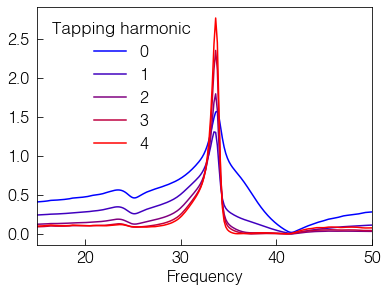

In [21]:
cs=plotting.bluered_colors(5)
for harmonic in range(5):
    normalized=(signals['Sn']/signals_ref['Sn'])[harmonic]
    np.abs(normalized).plot(color=next(cs),
                            label=harmonic)
for l in plt.gca().lines: l.set_xdata(l.get_xdata()/freq_THz)
plt.xlim(15,50)
plt.legend(title='Tapping harmonic')

## Energy spectroscopy

In [22]:
#--- Define function that will run our spectroscopy
# Make it auto-pickling so that subsequent `get..` calls reload rather than recompute the result

freqs = np.linspace(0,100,150)*freq_THz

@misc.autopickle('ProbeFreqSpectroscopy_taper=%i.pickle'%taper_angle)
def getFreqSpectroscopy(P,freqs = freqs):
    
    P.set_gap(gap0)
    P.get_mirror_impedance(sommerfeld=True,k=0,recompute=True)
    
    Spectroscopy = PS.ProbeSpectroscopyParallel(P, coords=freqs,
                                                eigenset_calculator=PS.compute_eigenset_at_freq,\
                                                ncpus=8, backend='multiprocessing', Nmodes=15, PhiM=False)
    Spectroscopy.classify_eigensets(Nmodes=10, reversed=True)
    
    return Spectroscopy

<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=4.5e-05


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=8.9e-05


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.00013


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.00018


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.00022


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.00027


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.00031
Finished freq=0, elapsed time: 5.9 s
Finished freq=4.5e-05, elapsed time: 9.7 s
Finished freq=8.9e-05, elapsed time: 9.8 s
Finished freq=0.00013, elapsed time: 10 s
Finished freq=0.00018, elapsed time: 10 s
Finished freq=0.00022, elapsed time: 10 s
Finished freq=0.00027, elapsed time: 10 s
Finished freq=0.00031, elapsed time: 10 s


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.00036


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0004


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.00045


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.00049


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.00054


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.00058


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.00063


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.00067
got results!
Finished freq=0.0004, elapsed time: 9.7 s
Finished freq=0.00036, elapsed time: 9.8 s
Finished freq=0.00045, elapsed time: 10 s
Finished freq=0.00054, elapsed time: 10 s
Finished freq=0.00049, elapsed time: 10 s
Finished freq=0.00063, elapsed time: 10 s
Finished freq=0.00058, elapsed time: 10 s
Finished freq=0.00067, elapsed time: 10 s


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.00072


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.00076


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.00081


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.00085


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.00089


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.00094


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.00098
got results!


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.001
Finished freq=0.00076, elapsed time: 11 s
Finished freq=0.00072, elapsed time: 11 s
Finished freq=0.00081, elapsed time: 12 s
Finished freq=0.00085, elapsed time: 12 s
Finished freq=0.00089, elapsed time: 12 s
Finished freq=0.00094, elapsed time: 12 s
Finished freq=0.00098, elapsed time: 12 s
Finished freq=0.001, elapsed time: 12 s


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0011


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0011


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0012


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0012
got results!


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0013


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0013


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0013


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0014
Finished freq=0.0011, elapsed time: 9.9 s
Finished freq=0.0011, elapsed time: 10 s
Finished freq=0.0012, elapsed time: 10 s
Finished freq=0.0012, elapsed time: 10 s
Finished freq=0.0013, elapsed time: 10 s
Finished freq=0.0013, elapsed time: 11 s
Finished freq=0.0013, elapsed time: 11 s
Finished freq=0.0014, elapsed time: 11 s


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0014


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0015


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0015


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0016


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0016


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0017


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0017


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0017
got results!
Finished freq=0.0014, elapsed time: 12 s
Finished freq=0.0016, elapsed time: 12 s
Finished freq=0.0015, elapsed time: 12 s
Finished freq=0.0015, elapsed time: 12 s
Finished freq=0.0016, elapsed time: 12 s
Finished freq=0.0017, elapsed time: 12 s
Finished freq=0.0017, elapsed time: 12 s
Finished freq=0.0017, elapsed time: 12 s


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0018


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0018


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0019


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0019


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.002


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.002


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


got results!
Starting freq=0.0021


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0021
Finished freq=0.0018, elapsed time: 11 s
Finished freq=0.0019, elapsed time: 11 s
Finished freq=0.0018, elapsed time: 11 s
Finished freq=0.0019, elapsed time: 11 s
Finished freq=0.002, elapsed time: 11 s
Finished freq=0.0021, elapsed time: 11 s
Finished freq=0.002, elapsed time: 11 s
Finished freq=0.0021, elapsed time: 12 s


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0021


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0022


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0022


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0023
got results!


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0023


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0024


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0024


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0025
Finished freq=0.0021, elapsed time: 12 s
Finished freq=0.0022, elapsed time: 12 s
Finished freq=0.0022, elapsed time: 12 s
Finished freq=0.0023, elapsed time: 12 s
Finished freq=0.0023, elapsed time: 12 s
Finished freq=0.0024, elapsed time: 12 s
Finished freq=0.0025, elapsed time: 12 s
Finished freq=0.0024, elapsed time: 12 s


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0025


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0026


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0026


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0026


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0027


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0027


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0028


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0028
got results!
Finished freq=0.0025, elapsed time: 12 s
Finished freq=0.0026, elapsed time: 12 s
Finished freq=0.0026, elapsed time: 12 s
Finished freq=0.0026, elapsed time: 12 s
Finished freq=0.0027, elapsed time: 12 s
Finished freq=0.0028, elapsed time: 12 sFinished freq=0.0027, elapsed time: 12 s

Finished freq=0.0028, elapsed time: 12 s


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0029


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0029


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.003


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.003


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.003


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0031


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0031


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0032
got results!
Finished freq=0.0029, elapsed time: 12 s
Finished freq=0.0029, elapsed time: 12 s
Finished freq=0.003, elapsed time: 12 s
Finished freq=0.003, elapsed time: 12 s
Finished freq=0.003, elapsed time: 12 s
Finished freq=0.0031, elapsed time: 12 s
Finished freq=0.0031, elapsed time: 12 s
Finished freq=0.0032, elapsed time: 13 s


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0032


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0033


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0033


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0034


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0034


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0034


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0035
got results!


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0035
Finished freq=0.0032, elapsed time: 12 s
Finished freq=0.0033, elapsed time: 13 s
Finished freq=0.0033, elapsed time: 13 s
Finished freq=0.0035, elapsed time: 13 s
Finished freq=0.0034, elapsed time: 13 s
Finished freq=0.0034, elapsed time: 13 s
Finished freq=0.0034, elapsed time: 13 s
Finished freq=0.0035, elapsed time: 13 s


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0036


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0036


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0037


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0037


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0038


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0038


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0038


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0039
got results!
Finished freq=0.0036, elapsed time: 13 s
Finished freq=0.0037, elapsed time: 13 s
Finished freq=0.0036, elapsed time: 13 s
Finished freq=0.0037, elapsed time: 13 s
Finished freq=0.0038, elapsed time: 13 s
Finished freq=0.0038, elapsed time: 13 s
Finished freq=0.0039, elapsed time: 13 s
Finished freq=0.0038, elapsed time: 13 s


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0039


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.004


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.004


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0041


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0041


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0042


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0042


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0043
got results!
Finished freq=0.004, elapsed time: 13 s
Finished freq=0.0039, elapsed time: 13 s
Finished freq=0.004, elapsed time: 13 s
Finished freq=0.0041, elapsed time: 13 s
Finished freq=0.0041, elapsed time: 14 s
Finished freq=0.0042, elapsed time: 14 s
Finished freq=0.0042, elapsed time: 14 s
Finished freq=0.0043, elapsed time: 14 s


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0043


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0043


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0044


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0044


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0045


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0045


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0046


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0046
got results!
Finished freq=0.0043, elapsed time: 14 s
Finished freq=0.0043, elapsed time: 14 s
Finished freq=0.0044, elapsed time: 15 s
Finished freq=0.0044, elapsed time: 15 s
Finished freq=0.0045, elapsed time: 15 s
Finished freq=0.0046, elapsed time: 15 s
Finished freq=0.0045, elapsed time: 15 s
Finished freq=0.0046, elapsed time: 15 s


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0047


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0047


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0047


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0048
got results!


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0048


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0049


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0049


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.005
Finished freq=0.0047, elapsed time: 15 s
Finished freq=0.0047, elapsed time: 15 s
Finished freq=0.0047, elapsed time: 15 s
Finished freq=0.0048, elapsed time: 15 s
Finished freq=0.0048, elapsed time: 15 s
Finished freq=0.0049, elapsed time: 15 s
Finished freq=0.0049, elapsed time: 15 s
Finished freq=0.005, elapsed time: 15 s


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.005


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0051


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0051


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0051


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0052


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0052


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0053


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0053
got results!
Finished freq=0.0051, elapsed time: 14 s
Finished freq=0.005, elapsed time: 14 s
Finished freq=0.0051, elapsed time: 15 s
Finished freq=0.0052, elapsed time: 15 s
Finished freq=0.0052, elapsed time: 15 s
Finished freq=0.0051, elapsed time: 15 s
Finished freq=0.0053, elapsed time: 15 s
Finished freq=0.0053, elapsed time: 15 s


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0054


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0054


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0055


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0055


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0055


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0056


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0056


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0057
got results!
Finished freq=0.0054, elapsed time: 15 s
Finished freq=0.0054, elapsed time: 15 s
Finished freq=0.0055, elapsed time: 15 s
Finished freq=0.0055, elapsed time: 15 s
Finished freq=0.0055, elapsed time: 15 s
Finished freq=0.0056, elapsed time: 16 s
Finished freq=0.0056, elapsed time: 16 s
Finished freq=0.0057, elapsed time: 16 s


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0057


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0058


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0058


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0059
got results!


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0059


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.006


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.006


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.006
Finished freq=0.0057, elapsed time: 16 s
Finished freq=0.0058, elapsed time: 16 s
Finished freq=0.0058, elapsed time: 16 s
Finished freq=0.0059, elapsed time: 16 s
Finished freq=0.0059, elapsed time: 16 s
Finished freq=0.006, elapsed time: 16 s
Finished freq=0.006, elapsed time: 16 s
Finished freq=0.006, elapsed time: 16 s


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0061


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0061


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0062


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0062


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0063


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0063


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0064


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':


got results!


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0064
Finished freq=0.0061, elapsed time: 16 s
Finished freq=0.0061, elapsed time: 16 s
Finished freq=0.0062, elapsed time: 16 s
Finished freq=0.0062, elapsed time: 16 s
Finished freq=0.0063, elapsed time: 16 s
Finished freq=0.0064, elapsed time: 16 s
Finished freq=0.0063, elapsed time: 16 s
Finished freq=0.0064, elapsed time: 16 s


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0064


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0065


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0065


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0066


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0066


/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Starting freq=0.0067
got results!
Finished freq=0.0064, elapsed time: 14 s
Finished freq=0.0065, elapsed time: 14 s
Finished freq=0.0065, elapsed time: 14 s
Finished freq=0.0066, elapsed time: 14 s
Finished freq=0.0066, elapsed time: 14 s
Finished freq=0.0067, elapsed time: 14 s
got results!
Time elapsed:  255.0214991569519
Classifying eigensets by eigenindex...
Classifying eigensets by eigenindex, with reversal...
<ProbeSpectroscopy.ProbeSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=10, there were 150 identifiable mutual coordinates.


Text(0.5, 0, 'Frequency')

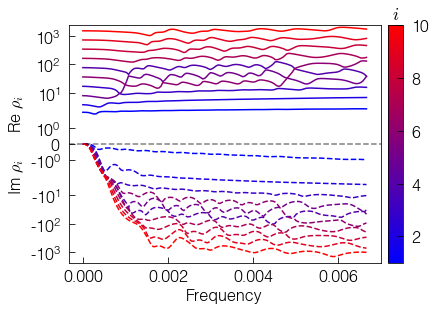

In [23]:
Spectroscopy = getFreqSpectroscopy(P,recompute=False,overwrite=False)
Spectroscopy.plot_eigenrhos()
#plt.gcf().axes[0].set_xlim(0,.001)
plt.gcf().axes[0].set_xscale('linear')
plt.gcf().axes[0].set_xlabel('Frequency')

### Kramers-Kronig analysis of eigenvalues

In [24]:
rhos=Spectroscopy.get_eigenrhos_AWA()
print(rhos.axis_names)

<ProbeSpectroscopy.ProbeSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=10, there were 150 identifiable mutual coordinates.
['eigenindex', 'coordinate']


Text(0, 0.5, '$1/\\rho_n$')

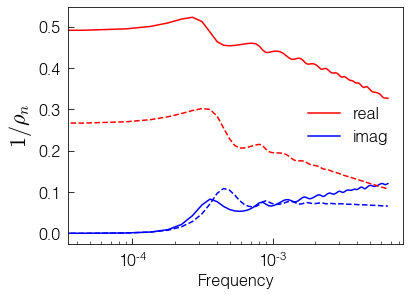

In [25]:
#--- See what some KK-compatible poles look like

(1/rhos[0]).real.plot(color='r',label='real')
(1/rhos[0]).imag.plot(color='b',label='imag')

(1/rhos[1]).real.plot(color='r',ls='--')
(1/rhos[1]).imag.plot(color='b',ls='--')

plt.legend()

plt.gca().set_xscale('log')
plt.xlabel('Frequency')
plt.ylabel(r'$1/\rho_n$',fontsize=22)

In [26]:
#--- Use a model (sum of lorentzians) to fit KK-compatible poles
def model_func(ws,params):
    
    Nosc=(len(params)-1)//3
    
    result=params[0]
    for iosc in range(Nosc):
        a,w1,w2=params[1+iosc*3:1+(iosc+1)*3]
        wresp=np.abs(w1)-1j*np.abs(w2)
        wresm=-np.abs(w1)-1j*np.abs(w2)
        result += np.abs(a)*(w1/(wresp-ws)-w1/(wresm-ws))
    
    return result

from common import numerical_recipes as numrec

In [27]:
#--- Fit this pole
n=0
X=1/rhos[n]

#--- Initial guess
params0=[.3]
for w1 in np.logspace(0,1,10)*.0003:
    params0+=[.05,w1,w1/3]

#--- Nonlinear least-squares (scipy.optimize.leastsq = Levenberg-Marquardt algo.)
result=numrec.ParameterFit(freqs,X,model_func,params0,\
                         limits=None,relative_error=False,\
                         verbose=False,error_exp=4,
                          ftol=1.49012e-12)[0]

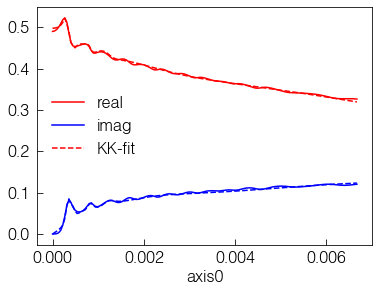

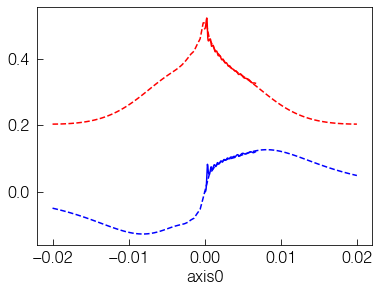

In [28]:
#--- Compare model pole to actual
Xtest=AWA(model_func(freqs,result),axes=[freqs])

X.real.plot(color='r',label='real')
X.imag.plot(color='b',label='imag')

Xtest.real.plot(color='r',ls='--',label='KK-fit')
Xtest.imag.plot(color='b',ls='--')

plt.legend()


plt.figure()
freqs2=np.linspace(-.02,.02,100)
Xtest=AWA(model_func(freqs2,result),axes=[freqs2])

X.real.plot(color='r')
X.imag.plot(color='b')

Xtest.real.plot(color='r',ls='--')
Xtest.imag.plot(color='b',ls='--')